## Understanding the Controls on Surface Water $CO_2$ Dynamics Using Hydrologic Data

### By: Ashif Abir; Date: 01/10/2022


# 1. Motivation of the Study
A significant amount of $CO_2$ is emitted from surface water bodies such as lakes, streams and wetlands. Hydrologic controls, such as discharge plays crucial role in parttioning between dissolved carbondioxide in water ($pCO_2$) and $CO_2$ evasion. Aside from discharge, surface water and channel characteristics such as velocity, water temperature, catchment slope, groundwater flow, land use, terrestrial to aquatic transport of organic matter etc have important roles in the release of $CO_2$ from water systems (Peter et al (2014). They also showed temporal and diurnal variation in $pCO_2$. Lauerwald et al (2015) also showed spatial variation in $pCO_2$ using statistical model, where higher amount of $pCO_2$ is ubiquitos within 30N to 30S latitude (Figure 1). Thus, the controls on the $CO_2$ gas efflux also varies to great extent at spatial and temporal scale. Different reaches across the same river or stream is expected to have variation in hydrologic parameters that should also lead to variation in partial pressue and efflux of $CO_2$. Moreover, during the hydrologic events such as storm events, gas transfer velocity varies accordingly due to high discharge and water velocity, causing the change in $CO_2$ dynamics. With higher turbulence, higher kinetic energy is attained to aid for higher evasion of $CO_2$ into the atmosphere than downstream transport. As Raymond et al. (2016) pointed out, about 86% of dissolved organic carbon is exported during hydrologic events which is expected to have influence on surface water $CO_2$ dynamics. Thus, it is of great interest to utilize surface water measurements from USGS (discharge, velocity, surface water temperature) and grab sample measurements by NEON ($pCO_2$) to determine evasion flux of $CO_2$. More specifically, the study aims at utilizing NEON's sporadic grab sample data to identify any correlation between driver parameters and evasion, and determining any seasonality of the same (if present). 

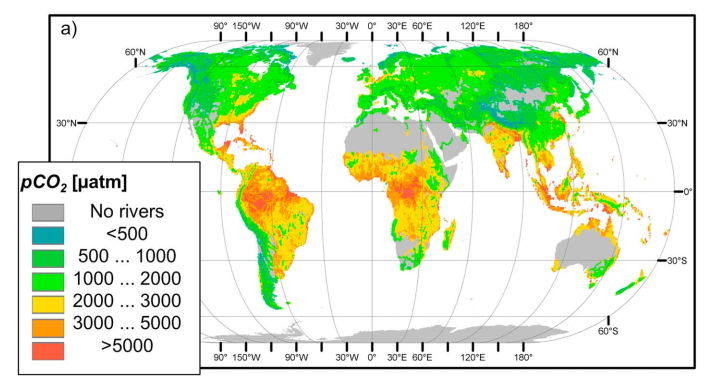
<div style="text-align: center"> Figure 1: Spatial Variation of $pCO_2$ (Peter et al., (2014)) </div>


## 1.1 Study Objective
Revisiting the surface water $CO_2$ dynamics, identifying potential driver parameters for $CO_2$ evasion and understanding the seasonality of the same.

# 2. Methods
## 2.1 Python Initialization and Loading Datasets

In [1]:
#Importing the Necessary Libraries and modules
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datetime import datetime
from pprint import pprint
import numpy as np                    
from matplotlib import pyplot as plt 
import datetime
import matplotlib.lines as mlines
from datetime import datetime
import math
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pearsonr
import folium

#%% Defining Variables and filenames
slope = 0.0024
khr = 0.34 #(M/atm) equillibrium coefficient
co2_a =410 #unit: micro-atm 
co2_a_mmolperL = 0.012
filenames = ['FLNT_FULL.txt', 'GHG_final.csv']
location = 'Fint River, Georgia'


#%% Creating an Interactive map for Study Sites
mapofGA = folium.Map(location=[30.97572, -84.611692], 
               tiles = 'OpenStreetMap')
# Adding markers for gauge sites 
folium.Marker(
    location=[31.185424, -84.437403], # Coordinates of NEON Site
    popup='NEON Site (FLNT)', # pop-up label for the marker
    icon=folium.Icon()
).add_to(mapofGA)

folium.Marker(
    location=[30.91030556, -84.58050000], # coordinates for USGS Site
    popup='USGS Site (USGS 02356000)', # pop-up label for the marker
    icon=folium.Icon()
).add_to(mapofGA)


#%% Reading NEON Data
cols_neon = ['timestamp','site','pCO2_uatm', 'CO2_uM']

neondata = pd.read_csv(filenames[1], usecols=cols_neon,
                     delimiter=',', comment='#', header=0,
                 parse_dates=['timestamp'], na_values = [-9999])

neondata = neondata.rename(columns = {'timestamp': 'date' })

#Rounding the timedate into rounded hours
neondata['date'] = neondata['date'].dt.round(freq='1H')

neondata = neondata.set_index(['date'])


startdates = pd.to_datetime('2017-04-18 00:00')
enddates = pd.to_datetime('2020-06-23 23:30')
neondata = neondata[startdates:enddates]


#%%Reading USGS Data [discharge, water teperature and velocity]
cols = ['20d','14n','14n.1', '14n.2']

dfusgs_flnt_full = pd.read_csv(filenames[0], usecols=cols,
              delimiter='\t', comment='#', header=1,
              parse_dates=['20d'], na_values = [-9999])

dfusgs_flnt_full = dfusgs_flnt_full.rename(columns={"20d": "date",
                                "14n": "velocity_fps",
                                  "14n.1": "discharge_cfs", "14n.2": "temp"})


dfusgs_flnt_full = dfusgs_flnt_full.set_index('date')


dfusgs_flnt_full['velocity_ms'] = dfusgs_flnt_full.velocity_fps/3.28  #velocity unit m/sec
dfusgs_flnt_full['discharge_m3s'] = dfusgs_flnt_full.discharge_cfs/35.315 #discharge unit m3/sec

#trimming for desired date range
dfusgs_flnt = dfusgs_flnt_full[startdates:enddates]

Merged_data = neondata.join(dfusgs_flnt)

## Resampling 15-min data into daily average data for discharge, velocity and temperature measurements
dailyusgs = dfusgs_flnt_full.resample('D').mean()


## 2.2 Site description

The site for this study is Flint River located in Georgia, United States (Figure 2). The river is non-wadable with flowing length of 554 Km (344 Miles). Flint river is chosen as it is situated in subtropical humid region. As predicted by Peter et al., (2014), higher partial pressure of $CO_2$ is prevalent between lattitudinal variation of 30N - 30S. Although reseachers have pointed out number of drivers for $pCO_2$ variation and $CO_2$ evasion, temperature and discharge have been widely regared to be key drivers of $CO_2$ evasion from surface water. Data collected by NEON also showed higher partial pressure of $CO_2$ ($pCO_2$), ranging from 1000 - 4000 micro-atm. The availability of $pCO_2$ measurements by NEON as well as the continuous measurements by USGS for temperature, discharge and velocity made it easier to choose Flint river for understanding the drivers of surface water $CO_2$ dynamics. The NEON site (Site ID: FLNT) is located within Jones Ecological Research Center (31.185424, -84.437403; elevation: 30 m). The site has mean annual temperature of 19.2 $^{\circ}$C and mean annual precipitation of 1311 mm. The USGS site is located at Bainbridge, GA (Site ID: 02356000). The NEON site provides grab sample data for *p*$CO_2$ ($\mu$atm) dated between 3/7/2017 - 6/23/2020. The surface water characteristics data (water temperature, discharge, velocity) were recorded at 15-min interval, starting from 6/1/2001 and ending on 1/11/2022 and were collected from USGS NWIS. An interactive map of the study region is provided in figure 3, the markers denoting the sites for NEON and USGS gauges.    
<br>
<div style="text-align: center"> Table 1: Specification of the data collected at Flint River, GA</div>

|Parameter|Site|Collecting Agency|Site ID|Data Frequency|Record Period|
|---|---|---|---|---|---|
|Discharge|Flint River|USGS|02356000|15-min interval|06/01/2001 - 01/11/2022|
|Velocity|Flint River|USGS|02356000|15-min interval|10/01/2007 - 01/11/2022|
|Water Temperature|Flint River|USGS|02356000|15-min interval|04/17/2017 - 01/11/2022|
|$pCO_2$|Flint River|NEON|FLNT|Grab Sample|3/07/2017 - 6/23/2020|

<br>

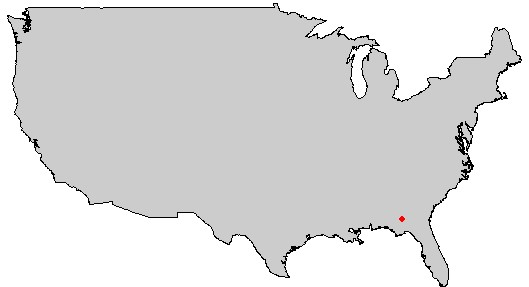
<div style="text-align: center"> Figure 2: Study Site Location (Created with RStudio) </div>
<br>
<br>
<br>
<br>
<br>



In [2]:
mapofGA

<div style="text-align: center"> Figure 3: Interactive map of Flint river section, markers denoting the location of USGS and NEON sites </div>
<br>
<br>
<br>
<br>

## 2.3 Calculation of $CO_2$ Evasion

To verify this further, Schmidt Number (N), normalized gas transfer velocity of $CO_2$ with respect to the same at Schmidt number of 600 ($K_{600}$), $CO_2$ transfer velocity ($K_{deg}$), Henry's law equilibrium coefficient ($K_h$) and $CO_2$ efflux (i.e., degassing) (gC/$m^2$-day) are calculated based on the analysis by Tian et al., (2015); Liu and Raymond (2018); Rocher-Ros et al., (2019); Raymond et al., (2012).

Schmidt number ($S_c$) is a dimensionless quantity that represents ratio of kinetic viscosity of water to the diffusion coefficient. Schmidt number is related to gas transfer velocity and is dependent on water temperature (Raymond et al., 2012). $S_c$ is determined using equation (1). Gas transfer velocity ($K_{600}$ is then calculated for Schmidt Number 0f 600 using USGS water velocity and assumed constant slope (Slope = 0.0024) as reported by Rugel et al., (2016) (Slope of flint river to be 2.4 m/Km) using equation (2). Using the normalized gas trasnfer velocity at Schmidt number 600 ($K_{600}$), degassing rate of $CO_2$ ($K_{deg}$) is calculated using eqution (3). Finally, the evasion flux of surface water $CO_2$ is calculated using equation (4). NEON's measurement for Surface water $CO_2$ concentration were used as $[CO_2]_w$, whereas $ [CO_2]_a$ = 0.012 $mmolL^-1$ is used as atmospheric concentration of $CO_2$ which is in equillibrium with water(equivalent to an adopted value of  410 ppm ambient $CO_2$ concentration recorded at Mauna Loa (unit conversion is performed as per Kimball (1990).

$S_c = 1911.1 - 118.11$ X $T_{water} + 3.4527$ X $T_{water}^2$ - $0.04132$ X $T_{water}^3$  - - - -(1) (Tian et al., (2015)
<br>
<br>
$K_{600} = Slope$ X  $Velocity$ X  $2841.6$ + $2.03$ - - - -(2) (Tian et al., (2015)
<br>
<br>
$K_{deg} = K_{600}$ X $(S_c/600)^{-0.5}$ - - - - (3)   (Raymond et al., 2012)
<br>
<br>
$Evasion Flux = K_{deg}$ X ($[CO_2]_w - [CO_2]_a$ )X 12 - - - -(4) (Liu and Raymond, 2018)

The NEON grab samples has been collected at arbitrary time of the day and has been rounded to nearest hour to keep the consistency with USGS dataset. The missing values in USGS dataset is filled in using forward filling interpolation method. Pearson Correlation is used to identify parameters that are potentially correlated with $pCO_2$ and $CO_2$ evasion. Seasonality of the driver parameters and $CO_2$ components are visualized using boxplot and polar plot.

In [3]:
# Creating Variables for the analysis
slope = 0.0024   #Slope of the catchment, 
khr = 0.34 #(M/atm) equillibrium coefficient
co2_a = 410 #unit: micro-atm 
co2_a_mmolperL = 0.012  #mmol/L

In [4]:
#%% Calculating the Evasion Flux from surface water
Merged_data['schmidtN'] = 1911.1-118.11*Merged_data.temp + 3.4527 * Merged_data.temp**2 - .04132*Merged_data.temp**3
Merged_data['k600'] = slope * Merged_data.velocity_ms * 2841.6 + 2.03
Merged_data['kdeg'] = Merged_data.k600 * (Merged_data.schmidtN/600)**-0.5 #Unit:m/day
Merged_data['co2_mmolperL'] = Merged_data.CO2_uM/1000  #converting co2 conc from micromol/l to mmol/l
Merged_data['co2_evasion'] = ((Merged_data.co2_mmolperL - co2_a_mmolperL) * Merged_data.kdeg *12) #Unit: gC/m2/day
Merged_data['epco2'] = Merged_data.co2_mmolperL / co2_a_mmolperL ##Determining excess pco2 compared to atmospheric conc



# 3.Results and Discussions



The Flint River at Georgia has high amount of partial pressure of $CO_2$ ($pCO_2$) in the water ranging from 712 to 4129 micro-atm. To put this into context, ratio of stream water and atmospheric $CO_2$ has been determined. Values larger than 1 denotes supersaturation, while values lesser than 1 denotes under saturation (Peter et al., 2014). For Flint river, we have always noticed oversaturation condition, the ratio being found ranging from 2.64 to 11.28 (Figure 4).

The measurements for discharge ($m^3s^{-1}$), velocity ($ms^{-1}$) and temperature (C) are plotted alongside partial pressure of $CO_2$ measurements, $pCO_2$ (micro-atm) for the full duration of data availabilty (Figure 5). Qualitatively, *p*$CO_2$ appears to be strongly related to water temperature, as both parameters are fluctuating in seemingly similar manner over time. Conversely, discharge appears to be seemingly negatively related to *p*$CO_2$.


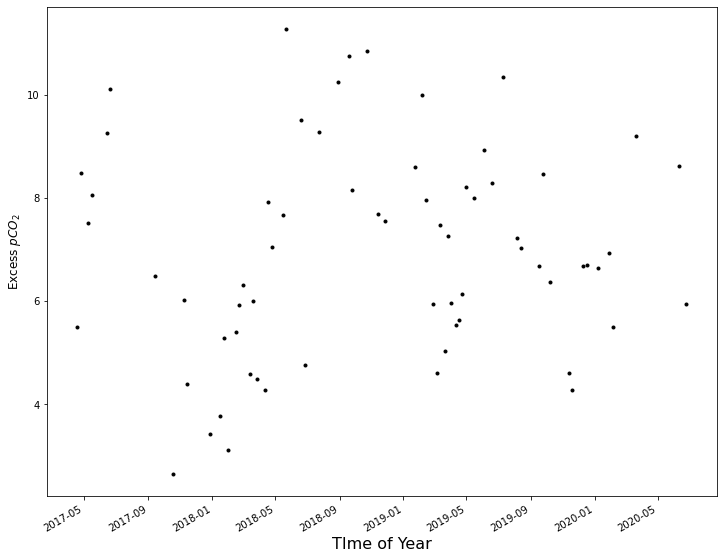

In [5]:
fig, (ax) = plt.subplots(figsize = (12,10))


ax.plot(Merged_data.index,Merged_data.epco2, label = 'epco2', color = 'k',
         marker = ".", linestyle = "None")
ax.set_ylabel('Excess $pCO_2$', color='k', size = 12)   
ax.set_xlabel('TIme of Year', color='k', size = 16)
fig.autofmt_xdate()
plt.show()


<div style="text-align: center"> Figure 4: Excess $pCO_2$ at Flint River, GA for the full durartion of record</div>
<br>
<br>

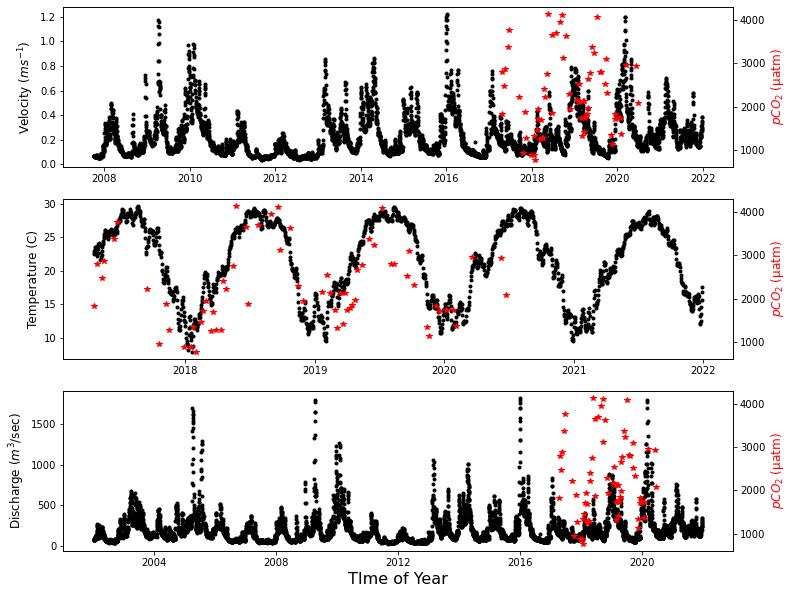

In [6]:
#%% Plot for Hydrologic characteristics
fig6, (ax11, ax13, ax15) = plt.subplots(3,1, figsize = (12,10))


ax11.plot(dailyusgs.index,dailyusgs.velocity_ms, label = 'velocity', color = 'k',
         marker = ".", linestyle = "None")
ax11.set_ylabel('Velocity ($ms^{-1})$', color='k', size = 12)   


ax12=ax11.twinx()

ax12.plot(Merged_data.index,Merged_data.pCO2_uatm, label = 'pCO2', 
          marker = "*", linestyle = "None", color = 'red')
ax12.set_ylabel('$pCO_2$ (\u03BCatm)', color='red', size = 12) 


ax13.plot(dailyusgs.index,dailyusgs.temp, label = 'temperature', color = 'k',
         marker = ".", linestyle = "None")
ax13.set_ylabel('Temperature (C)', color='k', size = 12)   


ax14=ax13.twinx()

ax14.plot(Merged_data.index,Merged_data.pCO2_uatm, label = 'pCO2', 
          marker = "*", linestyle = "None", color = 'red')
ax14.set_ylabel('$pCO_2$ (\u03BCatm)', color='red', size = 12) 



ax15.plot(dailyusgs.index,dailyusgs.discharge_m3s, label = 'discharge', color = 'k',
         marker = ".", linestyle = "None")
ax15.set_ylabel('Discharge ($m^3$/sec)', color='k', size = 12)   


ax16=ax15.twinx()

ax16.plot(Merged_data.index,Merged_data.pCO2_uatm, label = 'pCO2', 
          marker = "*", linestyle = "None", color = 'red')
ax16.set_ylabel('$pCO_2$ (\u03BCatm)', color='red', size = 12)   
ax15.set_xlabel('TIme of Year', color='k', size = 16)
plt.show()

<div style="text-align: center"> Figure 5: Hydrologic parameters (discharge, velocity, temperature) and $pCO_2$ measurements at Flint River, GA for the full durartion of record</div>
<br>
<br>
<br>

## 3.1 Correlation between the drivers of $CO_2$ evasion

Scatterplots are developed to visualize the response of $pCO_2$ with change in discharge and temperature (Figure 6). Discharge is not correlated with $pCO_2$ (pearson r = -0.14, p = 0.277), since $p$>0.05 denoting statistically insignificant. Aho et al., (2021) discusses similar chemostatic behaviour of $pCO_2$ with discharge. They opined such chemostatic can occur due to change in river metabolism during high flow events as runoff can supply high amount of organic matter or due to shift in carbonate buffering.
<br>
<br>
Temperature is found to be strongly correlated with $pCO_2$ (Pearson r = 0.72, $p$-value = 0.0). This can be attributed to higher metabolic activity in the river at higher temperature leading to increase in *p*$CO_2$ and vice versa.

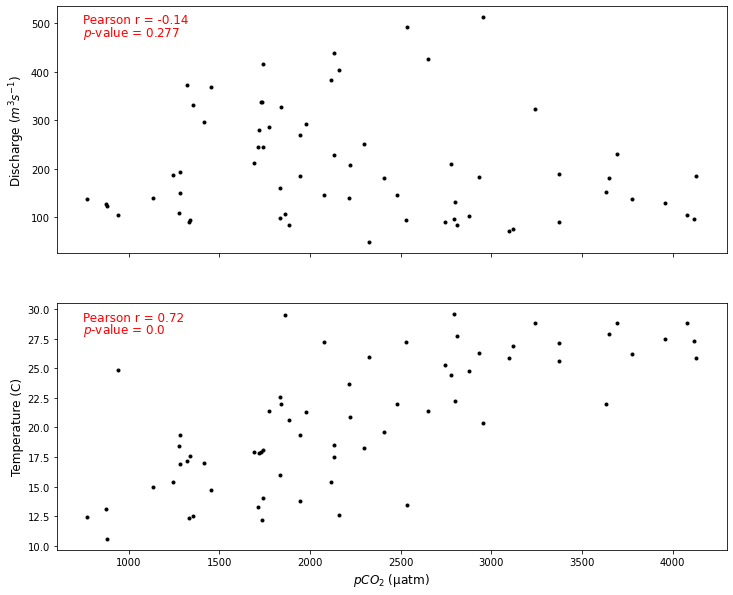

In [7]:
#%% Response of pCO2 with discharge and temperature
fig5, (ax111, ax112) = plt.subplots(2,1, sharex = True, figsize = (12,10))
ax111.plot(Merged_data.pCO2_uatm, Merged_data.discharge_m3s, '.', label = 'discharge-pCO2', color = 'black')
ax111.set_ylabel('Discharge ($m^3s^{-1}$)', color='k', size = 12)
ax111.annotate('Pearson r = -0.14', xy = (750,500), color = 'red', size = 12)
ax111.annotate('$p$-value = 0.277', xy = (750,475), color = 'red', size = 12)


ax112.plot(Merged_data.pCO2_uatm, Merged_data.temp, '.', label = 'discharge-evasion', color = 'black')
ax112.set_ylabel('Temperature (C)', color='k', size = 12)
ax112.annotate('Pearson r = 0.72', xy = (750,29), color = 'red', size = 12)
ax112.annotate('$p$-value = 0.0', xy = (750,28), color = 'red', size = 12)

ax112.set_xlabel('$pCO_2$ (\u03BCatm)', color='k', size = 12)

plt.show()


<div style="text-align: center"> Figure 6: Response of $pCO_2$ with change in water temperature and discharge</div>
<br>
<br>

Scatterplots are developed to visualize the response of $CO_2$ evasion with change in discharge and temperature (Figure 7). Both discharge (Pearson r = 0.44, $p$-value = 0.0002) and temperature (Pearson r = 0.39, $p$-value = 0.0011) are found to be moderately correlated with $CO_2$ evasion from water and are statistically significant ($p$-value < 0.005). With the increase in discharge, water turbulance also increases which provides kinetic energy and contributes to higher degassing of $CO_2$ from water, resulting in decrease in *p*$CO_2$. 


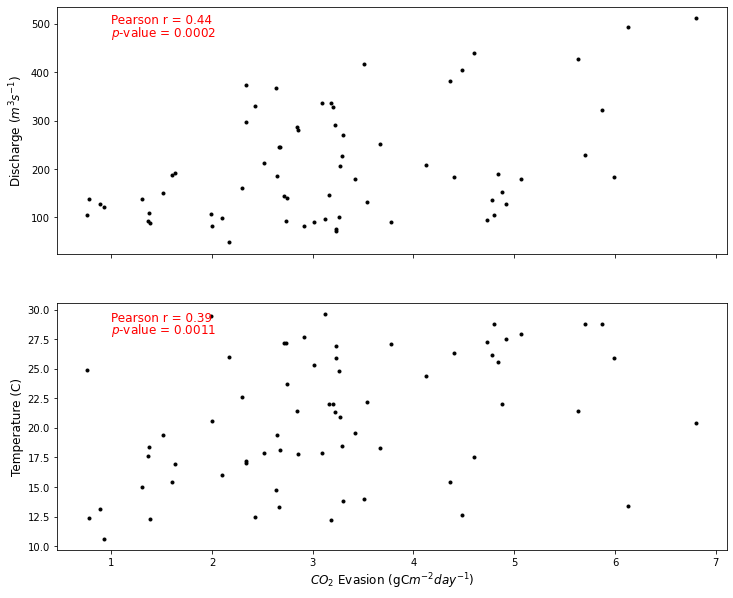

In [8]:
#%% Response of CO2 evasion with discharge and temperature
fig6, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = (12,10))
ax1.plot(Merged_data.co2_evasion, Merged_data.discharge_m3s, '.', label = 'discharge-pCO2', color = 'black')
ax1.set_ylabel('Discharge ($m^3s^{-1}$)', color='k', size = 12)
ax1.annotate('Pearson r = 0.44', xy = (1,500), color = 'red', size = 12)
ax1.annotate('$p$-value = 0.0002', xy = (1,475), color = 'red', size = 12)

ax2.plot(Merged_data.co2_evasion, Merged_data.temp, '.', label = 'discharge-evasion', color = 'black')
ax2.set_ylabel('Temperature (C)', color='k', size = 12)
ax2.annotate('Pearson r = 0.39', xy = (1,29), color = 'red', size = 12)
ax2.annotate('$p$-value = 0.0011', xy = (1,28), color = 'red', size = 12)

ax2.set_xlabel('$CO_2$ Evasion (gC$m^{-2}day^{-1}$)', color='k', size = 12)
   
plt.show()

<div style="text-align: center"> Figure 7: Response of $CO_2$ evasion with change in water temperature and discharge</div>
<br>
<br>

The pearson correlation coefficients were determined and plotted into a heatmap to visualize the relative dependence between parameters (Figure 8). The coefficient between $pCO_2$ and $CO_2$ evasion is found 0.73, meaning not all the excess $pCO_2$ present in water are not escaping to the atmosphere. Some of it is either getting converted / being used up by organisms or are being transported downstream of the river. More data are needed to undestand the fate of dissolved $CO_2$ gas in the water.

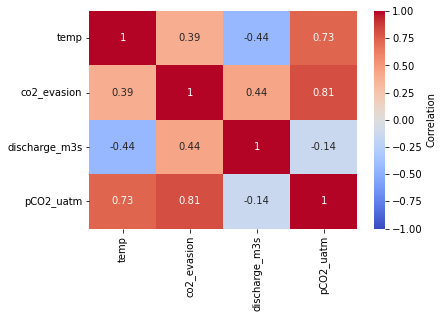

In [9]:
fff = pd.DataFrame([Merged_data["temp"], Merged_data["co2_evasion"],
                    Merged_data['discharge_m3s'],
                    Merged_data['pCO2_uatm']]).unstack().unstack()

fig2 = sns.heatmap(fff.corr(method='pearson'), cmap="coolwarm", annot = True, vmin = -1, vmax = 1, center=0,
                   cbar = True, cbar_kws={'label': 'Correlation'})
plt.show()


<div style="text-align: center"> Figure 8: Pearson correlation coefficient between the parameters</div>
<br>
<br>

The significance level ($p$-value) for the parameters in Pearson Correlation matrix are determined.

In [10]:
def pvaluecalc(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvaluecalc(fff) 

,temp,co2_evasion,discharge_m3s,pCO2_uatm
temp,0.0,0.0011,0.0002,0.0
co2_evasion,0.0011,0.0,0.0002,0.0
discharge_m3s,0.0002,0.0002,0.0,0.2772
pCO2_uatm,0.0,0.0,0.2772,0.0


## 3.2 Seasonality of $pCO_2$, $CO_2$ evasion and the associated driver parameters (temperature, discharge)


In [11]:
#%% Adding columns for DOY, month, year of datetime for the recorded USGS data
dailyusgs['day_of_year'] = dailyusgs.index.dayofyear
dailyusgs['year'] = dailyusgs.index.year
dailyusgs['month'] = dailyusgs.index.month

# Determining the average monthly parameter values
usgs_monthly = dailyusgs.groupby("month").mean()

#Adding column containing Julian Day corresponding to middle of each month
usgs_monthly['jdaymid'] = dailyusgs['day_of_year'].groupby(dailyusgs.index.month).median()

#Calculating the similar statistics for the pCO2 and co2 Evasion

Merged_data['month'] = Merged_data.index.month
Merged_data['day_of_year'] = Merged_data.index.dayofyear
Merged_data['year'] = Merged_data.index.year


merged_monthly = Merged_data.groupby("month").mean()
merged_monthly['jdaymid'] = Merged_data['day_of_year'].groupby(Merged_data.index.month).median()




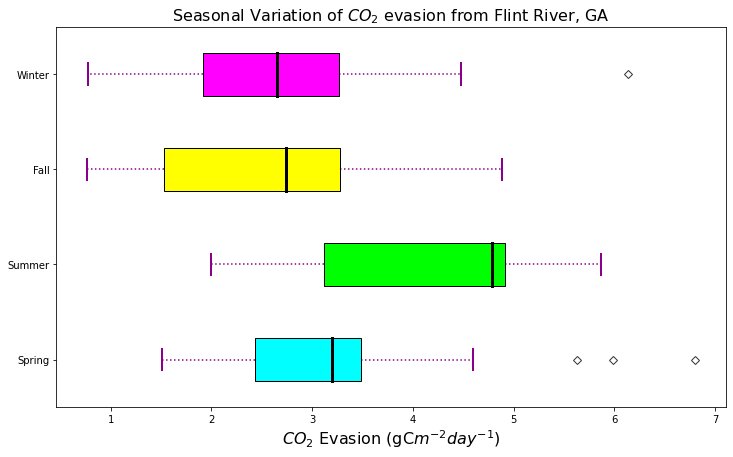

In [12]:
#Creating boxplots for visualizing seasonality in co2 evasion


spr = Merged_data[(Merged_data.month > 2) & (Merged_data.month < 6)]
summ = Merged_data[(Merged_data.month > 5) & (Merged_data.month < 9)]
fall = Merged_data[(Merged_data.month > 8) & (Merged_data.month < 12)]
wint = Merged_data[(Merged_data.month == 12) | (Merged_data.month < 3)]


seasons_eva = [spr.co2_evasion, summ.co2_evasion, fall.co2_evasion, 
               wint.co2_evasion]

#%%
fig = plt.figure(figsize =(12, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(seasons_eva, patch_artist = True,
                 vert = 0)
 
colors = ['cyan', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.8)
     
ax.set_yticklabels(['Spring', 'Summer',
                    'Fall', 'Winter'])
plt.title("Seasonal Variation of $CO_2$ evasion from Flint River, GA", size = 16)
ax.set_xlabel('$CO_2$ Evasion (gC$m^{-2}day^{-1}$)', color='k', size = 16)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show(bp)

<div style="text-align: center"> Figure 9: Seasonal varation of $CO_2$ evasion</div>


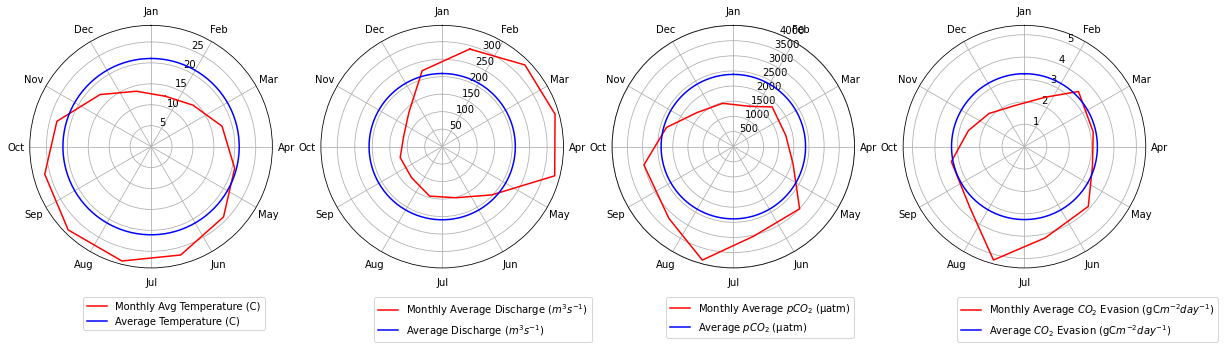

In [13]:
#Creating the Polar Plot for visualizing the seasonality


usgs_plot = usgs_monthly.append(usgs_monthly.iloc[0])
co2_plot = merged_monthly.append(merged_monthly.iloc[0])

# Create figure as polar plot and add monthly precipitation
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (20,15), subplot_kw={'projection': 'polar'})


####################################################################################################
ax1.plot(usgs_plot['jdaymid']*2*np.pi/365, 
        usgs_plot['temp'],
        label = 'Monthly Avg Temperature (C)',color = 'r')

# Add circular line at position of overall average monthly temp
ax1.plot(np.linspace(0, 2*np.pi, 100),    # create array of spaced points 0 <--> 2pi
        np.ones(100)*usgs_monthly.temp.mean(),          # create same-sized array full of avgpmonth
        color='b', linestyle='-',label='Average Temperature (C)')

# Set a total of 12 ticks and label with months
ax1.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Other plot options and labels
# ax1.set_title(plottitle)
ax1.legend(bbox_to_anchor=(.2,-0.1), loc='upper left')
ax1.set_theta_direction(-1)         # Flip data to go clockwise
ax1.set_theta_zero_location('N')    # Move January to top of plot

####################################################################################################
ax2.plot(usgs_plot['jdaymid']*2*np.pi/365, 
        usgs_plot['discharge_m3s'],
        label = 'Monthly Average Discharge ($m^3s^{-1}$)',color = 'r')
ax2.plot(np.linspace(0, 2*np.pi, 100),    
        np.ones(100)*usgs_monthly.discharge_m3s.mean(),     
        color='b', linestyle='-',label='Average Discharge ($m^3s^{-1}$)')
ax2.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.legend(bbox_to_anchor=(.2,-0.1), loc='upper left')
ax2.set_theta_direction(-1)         
ax2.set_theta_zero_location('N')  

####################################################################################################
ax3.plot(co2_plot['jdaymid']*2*np.pi/365, 
        co2_plot['pCO2_uatm'],
        label = 'Monthly Average $pCO_2$ (\u03BCatm)',color = 'r')
ax3.plot(np.linspace(0, 2*np.pi, 100),    
        np.ones(100)*merged_monthly.pCO2_uatm.mean(),       
        color='b', linestyle='-',label='Average $pCO_2$ (\u03BCatm)')
ax3.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.legend(bbox_to_anchor=(.2,-0.1), loc='upper left')
ax3.set_theta_direction(-1)         
ax3.set_theta_zero_location('N')    

###################################################################################################
ax4.plot(co2_plot['jdaymid']*2*np.pi/365, 
        co2_plot['co2_evasion'],
        label = 'Monthly Average $CO_2$ Evasion (gC$m^{-2}day^{-1}$)',color = 'r')
ax4.plot(np.linspace(0, 2*np.pi, 100),    
        np.ones(100)*merged_monthly.co2_evasion.mean(),       
        color='b', linestyle='-',label='Average $CO_2$ Evasion (gC$m^{-2}day^{-1}$)')
ax4.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))
ax4.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.legend(bbox_to_anchor=(.2,-0.1), loc='upper left')
ax4.set_theta_direction(-1)         
ax4.set_theta_zero_location('N')    

<div style="text-align: center"> Figure 10: Polar plot showing seasonality</div>
<br>
<br>
Inter-seasonal variation of $CO_2$ evasion plotted as boxplot in figure 9. Evasion tends to be similar during fall and winter. Median is the highest during summer, possibly due to coupled effect of higher temperature and primary production in the river in the summer providing the supply for more dissolved $CO_2$ to evade away. Spring has more extreme points. The outliers in the spring measurements could stem from higher discharge from snowmelt. 
<br>
<br>
Polar plot has been developed (figure 10) to demonstrate seasonality in discharge, water temperature, $pCO_2$ and $CO_2$ evasion, although seasonality index has not been determined. The plot tells temperature, $pCO_2$ and evasion were higher than yearly average in the summer, as expected. Discharge is higher during spring for snowmelts. The polar plot also implies that river metabolism might have greater influence on partial pressure of $CO_2$ and $CO_2$ evasion than discharge as they differ counterintuitively. We do not have enough data and analysis to effectively say which process could be determinant for $CO_2$ dynamics, we can see temperature should be one of the parameters. As pointed out by Schelker et al., (2016), river metabolic processes such as respiration and photosynthesis could be other controlling drivers for $pCO_2$ and the evasion for Flint River. 

## 4. Concluding Remarks and Future Study Directions

This study is intended to use concentration-discharge dynamics to see if the hydrologic conditionds (discharge, temperature, etc) is correlated to dissolved $CO_2$ and its evasion from surface water bodies. Temperature is found strongly correlated to partial pressure of $CO_2$ but moderately correlated to its evasion. Discharge is also found moderately correlated to evasion but not correlated to $pCO_2$. Seasonality is noticed in the polar plot for all the parameters, but seasonality index is not calculated for this study. $CO_2$ evasion is found higher during summer compared to other three seasons, but spring season contains more extreme evasion fluxes, ossibly due to high influx of water from snowmelts. 

<br>

For future study, ANOVA can be applied to determine seasonality. One of the biggest limitations of this study was the lack of continuous gas measurements. Studies have utilized NHDPlus database to determine $pCO_2$ from hydrologic data using Henry's law, although the accuracy of such approach is also a matter of discussion. Continuous measurements of $CO_2$ gas can enable to ask interesting novel questions related to this study. In particular, storm response for surface water $CO_2$ dynaics is yet to be demistified. For storm events, continuous measurements of $pCO_2$ as well as dissolved organic carbon would be useful to account for allochthonous carbon input during storms and precipitation events and to perform carbon mass balance of the system. Some studies have pointed out the diurnal variation of $CO_2$ evasion, which demands more attention. Building robust models that can utilize grab sample measurements of gases for coming up with continuous points can be extremely valuable, but would also be challenging. Since streams and river systems emit a significant amount of $CO_2$ to the atmosphere, better estimation of such is of great interest to build local and global models. As the process is highly variable in terms of temporal and spatial scale, global effort is also necessary for sharing regional data into a commonplace platform.  

# References

Ahmed, M., Else, B. G. T., Burgers, T. M., & Papakyriakou, T. (2019). Variability of surface water pCO2 in the Canadian Arctic Archipelago from 2010 to 2016. Journal of Geophysical Research: Oceans, 124(3), 1876-1896.

Aho, K. S., Fair, J. H., Hosen, J. D., Kyzivat, E. D., Logozzo, L. A., Rocher‐Ros, G., ... & Raymond, P. A. (2021). Distinct concentration‐discharge dynamics in temperate streams and rivers: CO2 exhibits chemostasis while CH4 exhibits source limitation due to temperature control. Limnology and Oceanography, 66(10), 3656-3668.

Kimball, B. A. (1990). Impact of carbon dioxide, trace gases, and climate change on global agriculture: proceedings of a symposium. American Society of Agronomy.

Lauerwald, R., Laruelle, G. G., Hartmann, J., Ciais, P., & Regnier, P. A. (2015). Spatial patterns in CO2 evasion from the global river network. Global Biogeochemical Cycles, 29(5), 534-554.

Liu, S., & Raymond, P. A. (2018). Hydrologic controls on pCO2 and CO2 efflux in US streams and rivers. Limnology and Oceanography Letters, 3(6), 428-435.

Peter, H., Singer, G. A., Preiler, C., Chifflard, P., Steniczka, G., & Battin, T. J. (2014). Scales and drivers of temporal pCO2 dynamics in an Alpine stream. Journal of Geophysical Research: Biogeosciences, 119(6), 1078-1091.

Raymond, P. A., Zappa, C. J., Butman, D., Bott, T. L., Potter, J., Mulholland, P., ... & Newbold, D. (2012). Scaling the gas transfer velocity and hydraulic geometry in streams and small rivers. Limnology and Oceanography: Fluids and Environments, 2(1), 41-53.

Rocher‐Ros, G., Sponseller, R. A., Lidberg, W., Mörth, C. M., & Giesler, R. (2019). Landscape process domains drive patterns of CO2 evasion from river networks. Limnology and Oceanography Letters, 4(4), 87-95.

RStudio Team (2020). RStudio: Integrated Development for R. RStudio, PBC, Boston, MA URL http://www.rstudio.com/

Rugel, K., Golladay, S. W., Jackson, C. R., & Rasmussen, T. C. (2016). Delineating groundwater/surface water interaction in a karst watershed: Lower Flint River Basin, southwestern Georgia, USA. Journal of Hydrology: Regional Studies, 5, 1-19.

Schelker, J., Singer, G. A., Ulseth, A. J., Hengsberger, S., & Battin, T. J. (2016). CO2 evasion from a steep, high gradient stream network: importance of seasonal and diurnal variation in aquatic pCO2 and gas transfer. Limnology and Oceanography, 61(5), 1826-1838.

Tian, H., Yang, Q., Najjar, R. G., Ren, W., Friedrichs, M. A., Hopkinson, C. S., & Pan, S. (2015). Anthropogenic and climatic influences on carbon fluxes from eastern North America to the Atlantic Ocean: A process‐based modeling study. Journal of Geophysical Research: Biogeosciences, 120(4), 757-772.
